In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import credentials
import requests
import datetime as dt
#pulling data API
key =credentials.login['key_isaham']  # extract password

In [2]:
def sector_filter(sector):

  # pulling data from api
  URL = 'https://admin.isaham.my/api/stocks/list'
  r = requests.get(url = URL) 
  data = r.json() 
  df = pd.DataFrame(data['stocks'],columns = ['code','symbol','name','primary-sector','secondary-sector'])

  wl = df[df["primary-sector"]==sector]
  wl = list(wl.symbol)

  return(wl)

In [3]:
def strategy_plan(wl,start_year):
    wp_acc=[]
    wp_only=[]
    total_trade=[]
    wr = []
    
    for m,stock in enumerate (wl):
        #print("----------------PROCESSING {}------------------".format(stock))
        #symbol = "UNISEM"  # which stock to pull
        symbol = stock    

        response = requests.get("https://admin.isaham.my/api/chart?stock={}&key={}".format(symbol,key))
        data = response.json()
        #print(data)

        #Tuning OB and OS level
        ob_cross=85
        os_cross=35

        df= pd.DataFrame.from_dict(data)
        df= df[['c','d','h','l','o','v']]
        df['d'] = pd.to_datetime(df['d'], dayfirst= True )
        #identify MA50
        n=50
        ma50=[] 

        for i in range(len(df["c"])-(n-1)):
            ma = round(sum(df["c"][i:i+(n)])/n,4)
            #print(ma)
            ma50.append(ma)

        df["MA50"] = pd.Series(ma50)
        df["MA50"] = df["MA50"].shift(n-1)

        #filter uptrend price above ma50
        # Calculating the gap of both MA
        df["MAgap"] = df["c"] -  df["MA50"] 

        df.set_index('d',inplace=True,drop=True)
        df.index.name = None

        #create signal for uptrend price above ma50 
        #result not accurate for stochastic when just filter uptrend only
        df["Uptrend"]=df['MAgap']>0
        Uptrend=df["Uptrend"]
        Uptrend_signal=Uptrend[Uptrend==True]
        #signal stochastic
        #Create the "L14" column in the DataFrame
        df['L14'] = df['l'].rolling(window=14).min()

        #Create the "H14" column in the DataFrame
        df['H14'] = df['h'].rolling(window=14).max()

        #Create the "%K" column in the DataFrame
        df['%K'] = 100*((df['c'] - df['L14']) / (df['H14'] - df['L14']) )

        #Create the "%D" column in the DataFrame
        df['%D'] = df['%K'].rolling(window=3).mean()

        #Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
        #A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
        df['Buy OS'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < os_cross) & (Uptrend_signal)

        #Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
        #A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
        df['Sell OB'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > ob_cross) 

        overbought =df['Sell OB']
        oversold =df['Buy OS']
        date_os=list(oversold[oversold == True].index)
        date_ob=list(overbought[overbought == True].index)
        
        # transaction recording for stochastic trading plan
        buy = []
        sell = []
        sdate = []
        bdate = []
        wr = []
        pct = []
        stock_name=[]
        for n,i in enumerate(date_os):
            #print(n,"Buy:", i, "Price:", df['c'].loc[i])
            buy.append(df['c'].loc[i])
            bdate.append(i)
            r=[]
            #print("before", len(r))
            for m,k in enumerate(date_ob):

                if k>i:
                    r.append(m)
                    #print('after',len(r))
                    if len(r) ==1:
                        #print(m,"Sell :", k, "Price:",df['c'].loc[k])
                        #print("Percentage change:",(((df['c'].loc[k]/df['c'].loc[i])-1)*100) )
                        sell.append(df['c'].loc[k])
                        sdate.append(k)
                        pct_change=((df['c'].loc[k]/df['c'].loc[i])-1)*100
                        pct.append(((df['c'].loc[k]/df['c'].loc[i])-1)*100)
                        stock_name.append(symbol)
                        
                    elif len(r)>1:
                        pass
        diff =len(buy)-len(sell)
        # Checking for final transaction, make sure it is sell, as we want to close the position
        if len(buy) == len(sell):
            #print("Yes \n", "Buy:", len(buy), "Sell:", len(sell))
            #print("Position closed")
            pass

        elif len(buy) != len(sell):
            #print("No, \n", "Buy:{}, Sell:{}, Closing the position".format(len(buy),len(sell)))
            del(buy[-diff:])
            del(bdate[-diff:])
            #print("Position closed")
        dct = {
        "Buy_Date": bdate,
        "Buy": buy,
        "Sell": sell,
        "Sell_Date": sdate,
        "Pct_change": pct,
        'Name_stock':stock_name }   
        trans = pd.DataFrame(dct)


        #define profit or loss
        for i in range(len(trans)):
            if trans["Pct_change"][i] > 0:
                wr.append(1)
            else:
                wr.append(0) 
        trans["wr"] = pd.Series(wr)

        trans.set_index('Buy_Date', inplace=True)

        #set date for period of backtest
        #trans=trans['01-01-2020':]        
        year=start_year
        date1 = "01-01-{}".format(start_year)  
        date2 = "01-01-{}".format(start_year+1)  
        #date3 =
        trans=trans[date1:date2]
        #print(trans)

        win_only=trans[trans["wr"]==1]
        #print(win_only)
        net_pct_win=round(sum(win_only['Pct_change']),4)
        wp_only.append(net_pct_win)
        #print(net_pct_win)

        #calculate net percentage
        net_pct=round(sum(trans['Pct_change']),4)
        wp_acc.append(net_pct)

        #calculate number of trade record
        num_trade=len(trans['wr'])
        total_trade.append(num_trade)

        #print('Stock :{}'.format(symbol))
        #print('When Overbought cross>{}.'.format(ob_cross))
        #print('When Oversold cross<{}.'.format(os_cross))
        #print("Winning rate at {}% for {} trades .".format(net_pct, len(trans["wr"])))
        #print("----------------DONE {}------------------".format(symbol)) 
    #print('######################### DONE DATA PREP ###########################')
    return(wp_acc,wp_only,total_trade,year)

        



In [4]:
def average_wr(wp_acc,wp_only,total_trade,year):

    avg_2 = round(sum(wp_acc)/len(wp_acc),4)
    total_win =sum(wp_only)/len(wp_only)
    total_num_trade =round(sum(total_trade),4)
    print("Overall Winning Rate in {} : {}%".format(year,avg_2))
    print('Total number of trade : {}'.format(total_num_trade))
    print("Average Winning Rate for win only : {}%".format(total_win)) 
    #print("############################## Finish #################################")
    return avg_2

In [5]:
def winning_rate(wl,start_year):
    
    wp_acc,wp_only,total_trade,year=strategy_plan(wl,start_year)
    avg_2=average_wr(wp_acc,wp_only,total_trade,year)
    #wp_acc,wp_only,total_trade=label_column(trans,symbo)
    
    return wp_acc,wp_only,total_trade,avg_2,year

### By sector performance

In [6]:
sectors=['Healthcare',
         'Telecommunications & Media',
         'Technology',
         'Utilities',
        'Energy',
        'Construction'
]

save_16=[]
name_sector_16=[]
year_16=[]

save_17=[]
name_sector_17=[]
year_17=[]

save_18=[]
name_sector_18=[]
year_18=[]

save_19=[]
name_sector_19=[]
year_19=[]

save_20=[]
name_sector_20=[]
year_20=[]

for sector in sectors:
    wl = sector_filter(sector)
    print(f"{sector}:")
    wp_acc,wp_only,total_trade,avg_2,year= winning_rate(wl,start_year=2016)
    save_16.append(avg_2)
    name_sector_16.append(sector)
    year_16.append(year)
    print('############################## DONE #################################') 
    
    print(year+1)
    wp_acc,wp_only,total_trade,avg_2,year= winning_rate(wl,start_year=2017)
    save_17.append(avg_2)
    name_sector_17.append(sector)
    year_17.append(year)
    print('############################## DONE #################################')  
    
    print(year+1)
    wp_acc,wp_only,total_trade,avg_2,year= winning_rate(wl,start_year=2018)
    save_18.append(avg_2)
    name_sector_18.append(sector)
    year_18.append(year)
    print('############################## DONE #################################') 
    
    print(year+1)
    wp_acc,wp_only,total_trade,avg_2,year= winning_rate(wl,start_year=2019)
    save_19.append(avg_2)
    name_sector_19.append(sector)
    year_19.append(year)
    print('############################## DONE #################################')  
    
    print(year+1)
    wp_acc,wp_only,total_trade,avg_2,year= winning_rate(wl,start_year=2020)
    save_20.append(avg_2)
    name_sector_20.append(sector)
    year_20.append(year)
    print('############################## DONE #################################') 

totalresult = save_16 + save_17 + save_18 +save_19 + save_20 
allsector = name_sector_16 + name_sector_17 + name_sector_18+name_sector_19 + name_sector_20 
record_y = year_16 + year_17 + year_18 + year_19 + year_20 


backtest= {
    "Sector": allsector,
    "Winning_Rate": totalresult,
    'Year': record_y
}  

# Save document for stochastic strategy
df_winning_rate = pd.DataFrame(backtest)

   

Healthcare:
Overall Winning Rate in 2016 : 12.742%
Total number of trade : 68
Average Winning Rate for win only : 26.522266666666667%
############################## DONE #################################
2017
Overall Winning Rate in 2017 : 44.5969%
Total number of trade : 79
Average Winning Rate for win only : 59.54838888888888%
############################## DONE #################################
2018
Overall Winning Rate in 2018 : -32.413%
Total number of trade : 82
Average Winning Rate for win only : 11.500044444444443%
############################## DONE #################################
2019
Overall Winning Rate in 2019 : 15.1658%
Total number of trade : 91
Average Winning Rate for win only : 44.957588888888885%
############################## DONE #################################
2020
Overall Winning Rate in 2020 : 100.4283%
Total number of trade : 95
Average Winning Rate for win only : 125.20988333333334%
############################## DONE #################################
Tele

In [13]:
totalresult = save_16 + save_17 + save_18 +save_19 + save_20 
allsector = name_sector_16 + name_sector_17 + name_sector_18+name_sector_19 + name_sector_20 
record_y = year_16 + year_17 + year_18 + year_19 + year_20 

backtest= {
    "Sector": allsector,
    "Winning_Rate": totalresult,
    'Year': record_y
}  

# Save document for stochastic strategy
df_winning_rate = pd.DataFrame(backtest)

In [14]:
df_winning_rate

,Sector,Winning_Rate,Year
0,Healthcare,12.7420,2016
1,Telecommunications & Media,0.4884,2016
2,Technology,13.8994,2016
3,Utilities,-3.7452,2016
4,Energy,-15.9559,2016
5,Construction,9.8652,2016
6,Healthcare,44.5969,2017
7,Telecommunications & Media,22.8049,2017
8,Technology,18.4620,2017
9,Utilities,9.3071,2017


In [15]:
sort_sector=df_winning_rate.sort_values(by="Sector")

### Construction

In [20]:
Construction=sort_sector[:5]
df_Construction=Construction.sort_values(by="Year")
df_Construction.set_index('Year',inplace=True)
df_Construction

,Sector,Winning_Rate
Year,,
2016,Construction,9.8652
2017,Construction,0.1006
2018,Construction,-32.0017
2019,Construction,-30.1680
2020,Construction,27.5280


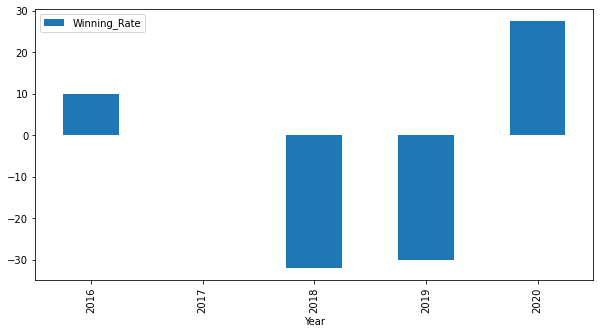

In [21]:
_ = df_Construction[['Sector','Winning_Rate']].plot.bar(figsize=(10, 5))

### Energy

In [24]:
Energy=sort_sector[5:10]
df_Energy=Energy.sort_values(by="Year")
df_Energy.set_index('Year',inplace=True)
df_Energy

,Sector,Winning_Rate
Year,,
2016,Energy,-15.9559
2017,Energy,20.0416
2018,Energy,-31.2155
2019,Energy,36.6170
2020,Energy,-30.5836


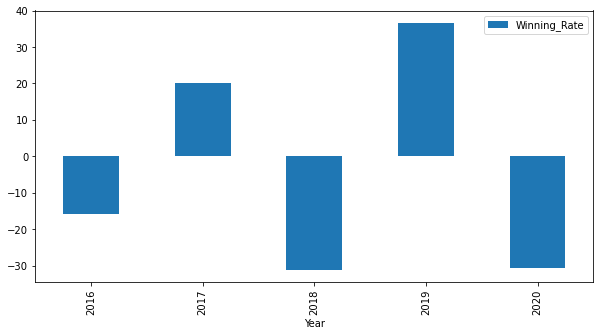

In [25]:
_ = df_Energy[['Sector','Winning_Rate']].plot.bar(figsize=(10, 5))

### Healthcare

In [27]:
Healthcare=sort_sector[10:15]
df_Healthcare=Healthcare.sort_values(by="Year")
df_Healthcare.set_index('Year',inplace=True)
df_Healthcare

,Sector,Winning_Rate
Year,,
2016,Healthcare,12.7420
2017,Healthcare,44.5969
2018,Healthcare,-32.4130
2019,Healthcare,15.1658
2020,Healthcare,100.4283


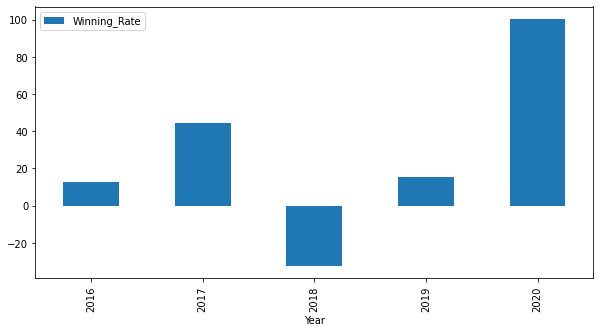

In [28]:
_ = df_Healthcare[['Sector','Winning_Rate']].plot.bar(figsize=(10, 5))

### Technology

In [29]:
Technology=sort_sector[15:20]
df_Technology=Technology.sort_values(by="Year")
df_Technology.set_index('Year',inplace=True)
df_Technology

,Sector,Winning_Rate
Year,,
2016,Technology,13.8994
2017,Technology,18.4620
2018,Technology,-26.8277
2019,Technology,-14.0943
2020,Technology,170.1138


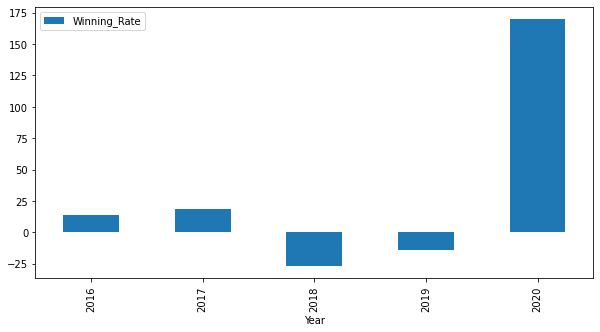

In [30]:
_ = df_Technology[['Sector','Winning_Rate']].plot.bar(figsize=(10, 5))

### Telecommunications & Media

In [31]:
Media=sort_sector[20:25]
df_Media=Media.sort_values(by="Year")
df_Media.set_index('Year',inplace=True)
df_Media

,Sector,Winning_Rate
Year,,
2016,Telecommunications & Media,0.4884
2017,Telecommunications & Media,22.8049
2018,Telecommunications & Media,-26.4375
2019,Telecommunications & Media,-1.0917
2020,Telecommunications & Media,114.1105


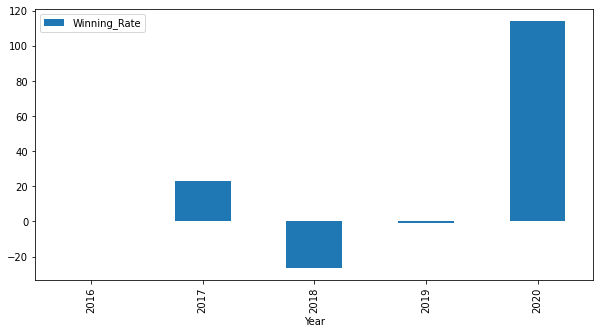

In [32]:
_ = df_Media[['Sector','Winning_Rate']].plot.bar(figsize=(10, 5))

### Utilities

In [33]:
Utilities=sort_sector[25:30]
df_Utilities=Utilities.sort_values(by="Year")
df_Utilities.set_index('Year',inplace=True)
df_Utilities

,Sector,Winning_Rate
Year,,
2016,Utilities,-3.7452
2017,Utilities,9.3071
2018,Utilities,-10.6202
2019,Utilities,40.5750
2020,Utilities,39.8938


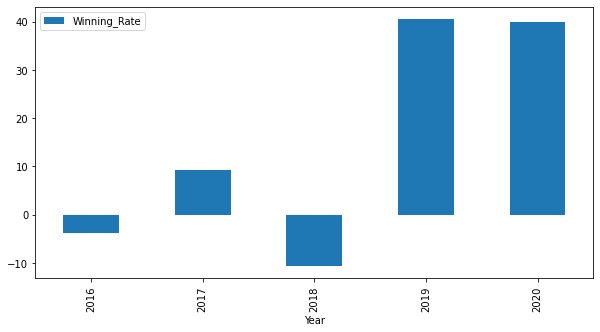

In [34]:
_ = df_Utilities[['Sector','Winning_Rate']].plot.bar(figsize=(10, 5))

###  Obtain trading plan winning rate for all sector last 5 years

In [16]:
sort_sector

,Sector,Winning_Rate,Year
29,Construction,27.5280,2020
23,Construction,-30.1680,2019
5,Construction,9.8652,2016
17,Construction,-32.0017,2018
11,Construction,0.1006,2017
22,Energy,36.6170,2019
4,Energy,-15.9559,2016
16,Energy,-31.2155,2018
28,Energy,-30.5836,2020
10,Energy,20.0416,2017


In [35]:
#sort_sector.to_csv (r'C:\Users\Mo Syamil\Documents\stochastic function\Graph for visualization of Winning rate.csv', index = False, header=True)

### All sector yearly

Healthcare:
Overall Winning Rate in 2016 : 12.742%
Total number of trade : 68
Average Winning Rate for win only : 26.522266666666667%
############################## DONE #################################
Telecommunications & Media:
Overall Winning Rate in 2016 : 0.4884%
Total number of trade : 121
Average Winning Rate for win only : 17.23648387096774%
############################## DONE #################################
Technology:
Overall Winning Rate in 2016 : 13.8994%
Total number of trade : 424
Average Winning Rate for win only : 46.87890465116277%
############################## DONE #################################
Utilities:
Overall Winning Rate in 2016 : -3.7452%
Total number of trade : 75
Average Winning Rate for win only : 14.394861538461537%
############################## DONE #################################
Energy:
Overall Winning Rate in 2016 : -15.9559%
Total number of trade : 124
Average Winning Rate for win only : 20.73304516129032%
############################## DONE

<BarContainer object of 6 artists>

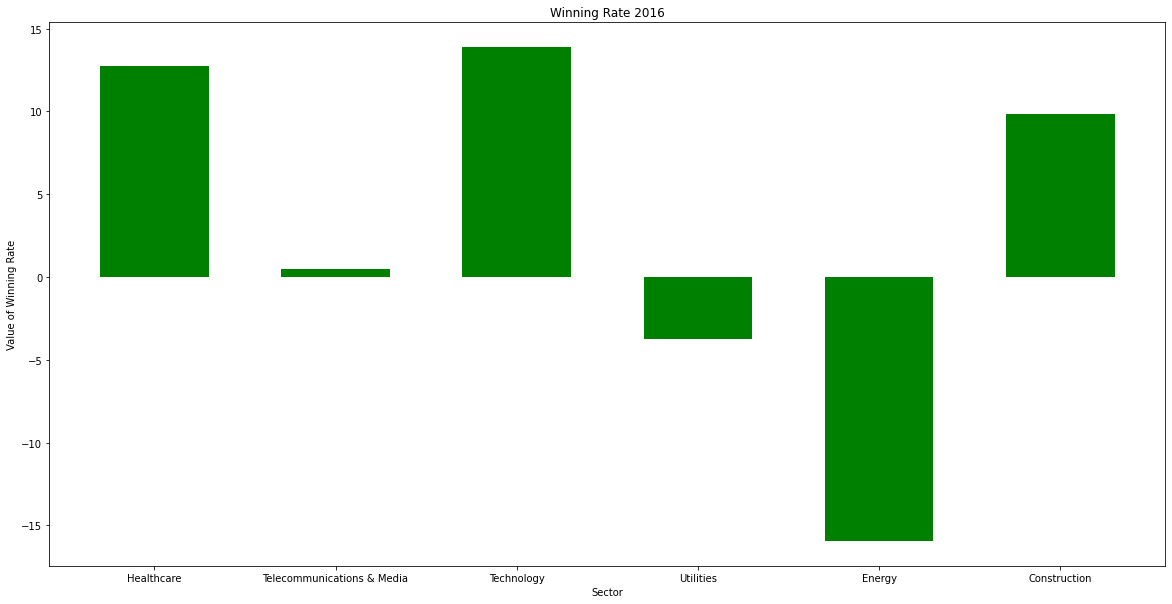

In [12]:
sectors=['Healthcare',
         'Telecommunications & Media',
         'Technology',
         'Utilities',
        'Energy',
        'Construction'
]

save=[]
name_sector=[]
for sector in sectors:
    wl = sector_filter(sector)
    print(f"{sector}:")
    wp_acc,wp_only,total_trade,avg_2,year= winning_rate(wl,start_year=2016)
    save.append(avg_2)
    name_sector.append(sector)
    print('############################## DONE #################################')
    
plt.figure(figsize=(20,10))
plt.title('Winning Rate {}'.format(year))
plt.xlabel('Sector')
plt.ylabel('Value of Winning Rate')

plt.bar(name_sector,save,0.6,color='g')